In [ ]:
!pip install imblearn
!pip install scikeras

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import statistics

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as IMBPipeline

# from scikeras.wrappers import KerasClassifier

In [ ]:
def get_sampling_count(y):
    count = Counter(y)
    harmonic_mean = round(statistics.harmonic_mean(count.values()))

    us_sample_count = {}
    os_sample_count = {}

    for key, value in count.items():
        if value > harmonic_mean:
            us_sample_count[key] = harmonic_mean
        elif value < harmonic_mean:
            os_sample_count[key] = harmonic_mean
        else:
            continue


    return us_sample_count, os_sample_count

## Keras

In [ ]:
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(15,8))
    sns.heatmap(cm, annot=True, fmt=".2g")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    # keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
EPOCHS = 5000
BATCH_SIZE = 256
monitor = 'val_loss'

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor, 
    verbose=0,
    patience=20,
    mode='min',
    restore_best_weights=True)

scheduling = keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,
    factor=0.5,
    patience=3,
    cooldown=0,
    verbose=0,
    mode="min",
    min_delta=0.0001,
    min_lr=1e-20
    )

def create_model(layers, dropout):

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(128,)))

    for i in range(len(layers)):
        model.add(keras.layers.Dense(layers[i], activation='relu'))

    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(7, activation='softmax'))

    return model


In [199]:
layers = [
    [4096],
    [2048],
    [4096, 2048],
    [4096, 2048, 1024],
    [2048, 1024]
]
dropouts = [0, 0.2, .5]
optimizers = [
    'adam',
    'adamax'
]
lr = [1e-3, 1e-4, 1e-5]
# dses = ['tess', 'ravdess', 'savee', 'crema', 'subesco', 'bser', 'all_bn', 'all_en', 'all']
dses = ['subesco']
# folder_names = ['vggish-emb', 'yamnet-emb']
folder_names = ['yamnet-emb']
# isAugs = [True, False]
isAugs = [False]

In [200]:
import itertools
import random

combinations = list(itertools.product(layers, dropouts, optimizers, dses, lr, folder_names, isAugs))

# len(combinations), combinations[0]

random_sample = random.sample(combinations, round(len(combinations)*0.2))

len(random_sample), random_sample[0], len(combinations), combinations[0]

(18,
 ([4096], 0.5, 'adamax', 'subesco', 0.001, 'yamnet-emb', False),
 90,
 ([4096], 0, 'adam', 'subesco', 0.001, 'yamnet-emb', False))

In [201]:
from tqdm import tqdm

results = []

for comb in tqdm(random_sample):
    print(comb)
    layer, dropout, optimizer, ds, lr, folder_name, isAug = comb

    if isAug:
        train_features = np.load(f'../input/{folder_name}/{ds}/train_aug_X.npy', allow_pickle=True)
        train_labels = np.load(f'../input/{folder_name}/{ds}/train_aug_y.npy', allow_pickle=True)
    else:
        train_features = np.load(f'../input/{folder_name}/{ds}/train_X.npy', allow_pickle=True)
        train_labels = np.load(f'../input/{folder_name}/{ds}/train_y.npy', allow_pickle=True)


    val_features = np.load(f'../input/{folder_name}/{ds}/val_X.npy', allow_pickle=True)
    val_labels = np.load(f'../input/{folder_name}/{ds}/val_y.npy', allow_pickle=True)
    test_features = np.load(f'../input/{folder_name}/{ds}/test_X.npy', allow_pickle=True)
    test_labels = np.load(f'../input/{folder_name}/{ds}/test_y.npy', allow_pickle=True)

#     print('before:', train_features.shape, train_labels.shape)
#     sns.countplot(train_labels)
#     plt.show()
    under, over = get_sampling_count(train_labels)
    under_sample = RandomUnderSampler(sampling_strategy=under)
    over_sample = RandomOverSampler(sampling_strategy=over)
    train_features, train_labels = under_sample.fit_resample(train_features, train_labels)
    train_features, train_labels = over_sample.fit_resample(train_features, train_labels)
#     print('After:', train_features.shape, train_labels.shape)
#     sns.countplot(train_labels)
#     plt.show()


    labels = np.unique(train_labels)

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)
    train_labels = train_labels.reshape(-1, 1)
    val_labels = val_labels.reshape(-1, 1)
    test_labels = test_labels.reshape(-1, 1)
    
    encoder = OneHotEncoder()
    train_labels = encoder.fit_transform(train_labels).toarray()
    val_labels = encoder.transform(val_labels).toarray()
    test_labels = encoder.transform(test_labels).toarray()


    # Model creation
    out = len(labels)

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(train_features.shape[-1],)))

    for i in range(len(layers)):
        model.add(keras.layers.Dense(layers[i][0], activation='relu'))
    
    if dropout != 0:
        model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(out, activation='softmax'))

    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'adamax':
        opt = keras.optimizers.Adamax(learning_rate=lr)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=METRICS
    )
    model.fit(train_features, train_labels, validation_data=(val_features, val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, scheduling], verbose=0)
    
    res = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)
    true = encoder.inverse_transform(test_labels)
    preds = encoder.inverse_transform(test_predictions)

    results.append(
        {
            'info': comb,
            'res': res,
            'f1_weighted': f1_score(true, preds, average='weighted'),
            'accuracy': accuracy_score(true, preds),
            'cm': confusion_matrix(true, preds),
            'report': classification_report(true, preds, digits=4)
        }
    )
#     break


  0%|          | 0/18 [00:00<?, ?it/s]

([4096], 0.5, 'adamax', 'subesco', 0.001, 'yamnet-emb', False)


  6%|▌         | 1/18 [01:26<24:35, 86.81s/it]

([2048, 1024], 0, 'adamax', 'subesco', 0.0001, 'yamnet-emb', False)


 11%|█         | 2/18 [02:22<18:15, 68.44s/it]

([4096, 2048], 0.5, 'adamax', 'subesco', 1e-05, 'yamnet-emb', False)


 17%|█▋        | 3/18 [04:20<22:45, 91.01s/it]

([4096, 2048, 1024], 0.2, 'adamax', 'subesco', 0.001, 'yamnet-emb', False)


 22%|██▏       | 4/18 [05:16<18:03, 77.39s/it]

([4096], 0.2, 'adam', 'subesco', 0.0001, 'yamnet-emb', False)


 28%|██▊       | 5/18 [06:05<14:33, 67.20s/it]

([2048], 0, 'adam', 'subesco', 0.0001, 'yamnet-emb', False)


 33%|███▎      | 6/18 [06:56<12:20, 61.69s/it]

([4096, 2048], 0, 'adam', 'subesco', 0.0001, 'yamnet-emb', False)


 39%|███▉      | 7/18 [08:22<12:43, 69.37s/it]

([4096], 0, 'adamax', 'subesco', 0.0001, 'yamnet-emb', False)


 44%|████▍     | 8/18 [09:47<12:24, 74.49s/it]

([2048], 0.2, 'adamax', 'subesco', 0.001, 'yamnet-emb', False)


 50%|█████     | 9/18 [10:43<10:17, 68.58s/it]

([4096], 0.5, 'adamax', 'subesco', 1e-05, 'yamnet-emb', False)


 56%|█████▌    | 10/18 [12:45<11:22, 85.34s/it]

([4096, 2048], 0.5, 'adam', 'subesco', 0.001, 'yamnet-emb', False)


 61%|██████    | 11/18 [14:11<09:57, 85.30s/it]

([2048, 1024], 0.5, 'adam', 'subesco', 0.001, 'yamnet-emb', False)


 67%|██████▋   | 12/18 [15:04<07:32, 75.46s/it]

([4096, 2048], 0.5, 'adamax', 'subesco', 0.001, 'yamnet-emb', False)


 72%|███████▏  | 13/18 [15:57<05:43, 68.72s/it]

([4096, 2048], 0, 'adam', 'subesco', 0.001, 'yamnet-emb', False)


 78%|███████▊  | 14/18 [17:22<04:54, 73.71s/it]

([2048], 0.5, 'adamax', 'subesco', 0.0001, 'yamnet-emb', False)


 83%|████████▎ | 15/18 [18:18<03:25, 68.41s/it]

([4096, 2048], 0, 'adamax', 'subesco', 0.0001, 'yamnet-emb', False)


 89%|████████▉ | 16/18 [19:15<02:09, 64.85s/it]

([2048], 0.2, 'adam', 'subesco', 0.001, 'yamnet-emb', False)


 94%|█████████▍| 17/18 [20:40<01:11, 71.02s/it]

([4096, 2048], 0.2, 'adam', 'subesco', 0.0001, 'yamnet-emb', False)


100%|██████████| 18/18 [22:05<00:00, 73.66s/it]


In [202]:
import pickle
with open(f'{dses[0]}.pkl', 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

In [203]:
df = pd.DataFrame(results)
df[:5]

,info,res,f1_weighted,accuracy,cm,report
0,"([4096], 0.5, adamax, subesco, 0.001, yamnet-e...","[1.5626097917556763, 1545.0, 1148.0, 50962.0, ...",0.376478,0.397697,"[[642, 89, 86, 81, 34, 18, 182], [290, 137, 84...",precision recall f1-score ...
1,"([2048, 1024], 0, adamax, subesco, 0.0001, yam...","[1.575840711593628, 1491.0, 1135.0, 50975.0, 7...",0.379343,0.386528,"[[582, 174, 63, 118, 43, 65, 87], [230, 234, 8...",precision recall f1-score ...
2,"([4096, 2048], 0.5, adamax, subesco, 1e-05, ya...","[1.564314365386963, 1500.0, 1097.0, 51013.0, 7...",0.390755,0.400230,"[[579, 174, 68, 95, 45, 23, 148], [209, 231, 8...",precision recall f1-score ...
3,"([4096, 2048, 1024], 0.2, adamax, subesco, 0.0...","[1.571004867553711, 1784.0, 1455.0, 50655.0, 6...",0.388186,0.403569,"[[597, 169, 59, 90, 41, 18, 158], [236, 220, 9...",precision recall f1-score ...
4,"([4096], 0.2, adam, subesco, 0.0001, yamnet-em...","[1.6709253787994385, 1138.0, 891.0, 51219.0, 7...",0.317110,0.367530,"[[837, 23, 43, 78, 78, 13, 60], [465, 71, 55, ...",precision recall f1-score ...


In [204]:
df = df.sort_values(by='f1_weighted', ascending=False, )
df.reset_index(inplace=True)
df[:5]

,index,info,res,f1_weighted,accuracy,cm,report
0,2,"([4096, 2048], 0.5, adamax, subesco, 1e-05, ya...","[1.564314365386963, 1500.0, 1097.0, 51013.0, 7...",0.390755,0.400230,"[[579, 174, 68, 95, 45, 23, 148], [209, 231, 8...",precision recall f1-score ...
1,3,"([4096, 2048, 1024], 0.2, adamax, subesco, 0.0...","[1.571004867553711, 1784.0, 1455.0, 50655.0, 6...",0.388186,0.403569,"[[597, 169, 59, 90, 41, 18, 158], [236, 220, 9...",precision recall f1-score ...
2,9,"([4096], 0.5, adamax, subesco, 1e-05, yamnet-e...","[1.5528210401535034, 1446.0, 1061.0, 51049.0, ...",0.381916,0.394243,"[[543, 168, 72, 103, 40, 29, 177], [201, 234, ...",precision recall f1-score ...
3,7,"([4096], 0, adamax, subesco, 0.0001, yamnet-em...","[1.565265417098999, 1066.0, 686.0, 51424.0, 76...",0.380650,0.389292,"[[541, 222, 44, 118, 45, 37, 125], [183, 283, ...",precision recall f1-score ...
4,1,"([2048, 1024], 0, adamax, subesco, 0.0001, yam...","[1.575840711593628, 1491.0, 1135.0, 50975.0, 7...",0.379343,0.386528,"[[582, 174, 63, 118, 43, 65, 87], [230, 234, 8...",precision recall f1-score ...


In [205]:
df['info'][0]

([4096, 2048], 0.5, 'adamax', 'subesco', 1e-05, 'yamnet-emb', False)

<AxesSubplot:>

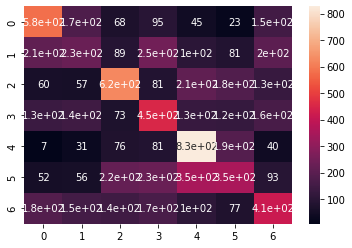

In [206]:
cm = df['cm'][0]
sns.heatmap(cm, annot=True)